In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
file = open("data_rus_adasyn_risk2","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [3]:
X_train.head(2)

,menopaus_0,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,agegrp_10,...,race_5,hispanic_0,hispanic_1,bmi_3,bmi_4,agefirst_1,agefirst_2,nrelbc_0,nrelbc_2,lastmamm_1
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


In [4]:
X_train.shape

(16577, 25)

In [5]:
X_test.shape

(59501, 25)

# Model Building on Cancer Data

## <span style="color:blue">Model 3 - XGBoost</span>

### Default Hyperparameters

Let's first fit a random forest model with default hyperparameters.

In [6]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi=TP / float(TP+FN)
    speci=TN / float(TN+FP)
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)
    print("Average of Sensitivity and Specificity:", (sensi+speci)/2)
    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

In [7]:
# Importing random forest classifier from sklearn library
from xgboost import XGBClassifier

In [8]:
# We can now find the optimal hyperparameters using GridSearchCV.
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

### Hyperparameter Tuning : Grid Search to Find Optimal Hyperparameters

We can now use GridSearchCV to find multiple optimal hyperparameters together.

The following hyperparameters are present in a random forest classifier. Note that most of these hypereparameters are actually of the decision trees that are in the forest.
- **max_depth** : integer or None, optional (default=None)The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **min_samples_leaf** : int, float, optional (default=1)The minimum number of samples required to be at a leaf node:**
- **min_samples_split** : int, float, optional (default=2)The minimum number of samples required to split an internal node:**
- **n_estimators**: integer, optional (default=10): The number of trees in the forest.
- **criterion**: string, optional (default=”gini”)The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
- **max_features** : int, float, string or None, optional (default=”auto”)The number of features to consider when looking for the best split:

In [9]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [150,250,300]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.6s finished


best accuracy 0.7171113060908353
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


we choose n_estimators as 150

In [10]:
# Create the parameter grid based on the results of random search 
param_grid = {
   # 'max_depth': [5,7,9],
    'min_child_weight' : [3,5,7]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 gamma=0,
 max_depth=6,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

xgb.fit(X_train,y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   23.3s finished


best accuracy 0.7157030072692494
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [12]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5,7,8]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 gamma=0,
 min_child_weight=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

xgb.fit(X_train,y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.6s finished


best accuracy 0.7155505760215413
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [13]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'gamma': [.1,.2,.3,.4,.5]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=6,
 min_child_weight=1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.6s finished


best accuracy 0.7167165110325895
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [14]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=6,
 min_child_weight=1,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished


best accuracy 0.717625787160393
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [15]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'reg_alpha':[0.001, 0.005, 0.01, 0.05]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=6,
 min_child_weight=1,
 subsample=0.9,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid,  scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   15.6s finished


best accuracy 0.717679725074608
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [16]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'reg_lambda':[0.5,0.6,0.7,0.8,0.9]
}

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=6,
 min_child_weight=1,
 subsample=0.9,
 colsample_bytree=0.7,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid,  scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.4s finished


best accuracy 0.7167047127579508
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.001, reg_lambda=0.6,
              scale_pos_weight=1, seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [17]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=6,
 min_child_weight=1,
 subsample=0.9,
 colsample_bytree=0.7,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Fit the grid search to the data
xgb.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

Confusion Matrix ->
[[6260 2326]
 [2224 5767]]
Accuracy: 0.7255233154370513
Sensitivity: 0.72168689775998
Specificity: 0.7290938737479618
Average of Sensitivity and Specificity: 0.7253903857539709
Precision 0.7125911281354257
MCC  0.45061566970467226
F1  0.7171101715991047
F2  0.7198492148688119
F3  0.7207668849672548
ROC-AUC : 0.81


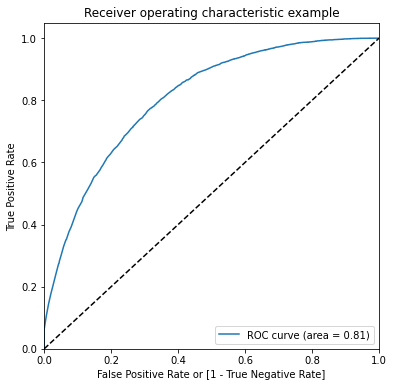

In [18]:
#### Model evaluation on train data

# Predicting on test dataframe using predict
y_pred_train = xgb.predict(X_train)
model_stats(X_train, y_train, y_pred_train, xgb)

Confusion Matrix ->
[[37774 20156]
 [  534  1037]]
Accuracy: 0.6522747516848456
Sensitivity: 0.66008911521324
Specificity: 0.6520628344553772
Average of Sensitivity and Specificity: 0.6560759748343086
Precision 0.04893125088472609
MCC  0.10451170916434555
F1  0.09110876823053944
F2  0.1887032791061615
F3  0.29350164157138003
ROC-AUC : 0.71


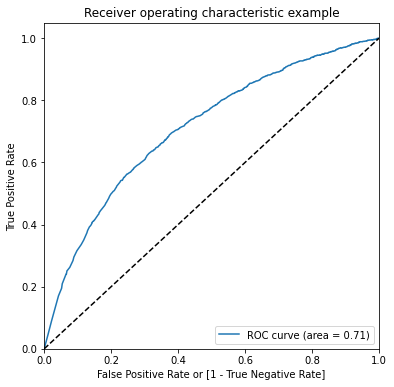

In [19]:
#### Model evaluation on test data

# Predicting on test dataframe using predict

y_pred_test = xgb.predict(X_test)
#y_pred_test=(xgb.predict_proba(X_test)[:,1] > 0.51).astype(bool)

model_stats(X_test, y_test, y_pred_test, xgb)